# Station Air Pollution Estimation

For each station, find a good model to predict the individual pollutants.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns


from utils import *

datasets_folder = './datasets'
verbosity=0

## Data Import

In [2]:
giardini_margherita_pollution_dict, san_felice_pollution_dict, chiarini_pollution_dict = read_and_preprocess_dataset(datasets_folder, 'pollution', resample=False, v=verbosity)
giardini_margherita_traffic_df, san_felice_traffic_df, chiarini_traffic_df = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)
weather_df = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

In [3]:
giardini_margherita_data = prepare_station_data_for_training(giardini_margherita_pollution_dict, giardini_margherita_traffic_df, weather_df)
san_felice_data = prepare_station_data_for_training(san_felice_pollution_dict, san_felice_traffic_df, weather_df)
chiarini_data = prepare_station_data_for_training(chiarini_pollution_dict, chiarini_traffic_df, weather_df)

## Models

For each station we develop a model to describe the air pollution. Given that each station collects different data, and sometimes with different intensities, we decided to treat each station indepentendtely.

Air polution follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The overage value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <30             | EXCELLENT      |
| From 34 to 66   | GOOD           |
| From 67 to 99   | FAIR           |
| From 99 to 150  | POOR           |
| >150            | VERY POOR      |

We are going to model each agent to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the readings.

In [4]:
pollutant_limits = {
    'PM2.5': 25,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 180,      # µg/m³
    'NO': None,     # µg/m³
    'NO2': 200,     # µg/m³
    'NOX': None,    # µg/m³
    'C6H6': None    # µg/m³
}

In [5]:
from sklearn.ensemble import RandomForestClassifier

train_split_date = datetime(2023,12,31,23)

### Giardini Margherita

- **NO2**

In [13]:
no2_x_train, no2_y_train, no2_x_test, no2_y_test = create_train_test(giardini_margherita_data['NO2'], train_split_date, y='Agent_value')

In [37]:
no2_clf = RandomForestClassifier(random_state=42)

no2_clf.fit(no2_x_train,no2_y_train['Agent_value'])

RandomForestClassifier(random_state=42)

In [38]:
no2_y_pred = no2_clf.predict(no2_x_test)

In [39]:
no2_y_pred_df = pd.DataFrame(no2_y_pred, index=no2_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

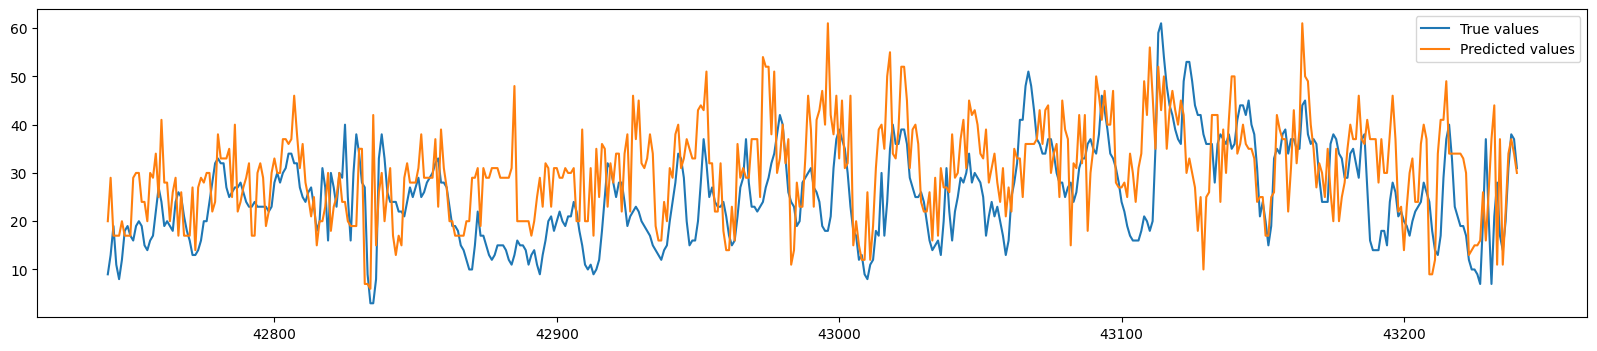

In [40]:
plt.figure(figsize=(20,4))
plt.plot(no2_y_test.iloc[:500], label='True values')
plt.plot(no2_y_pred_df.iloc[:500], label='Predicted values')
plt.legend()
plt.show()